# The ConvLSTM2d notebook

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features
- y-sets are normalized (MinMax)
- Removes repeated values in y-set B and C

### Uses the data preprocessing from Cat_boost.ipynb


###  VERSION 1

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [66]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

## Handling the Y-set

In [67]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True
            
    threshold = 6

    return sorted([t for t in intervals if t[1] - t[0] >= threshold], key=lambda t: t[1] - t[0], reverse=True)

In [68]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


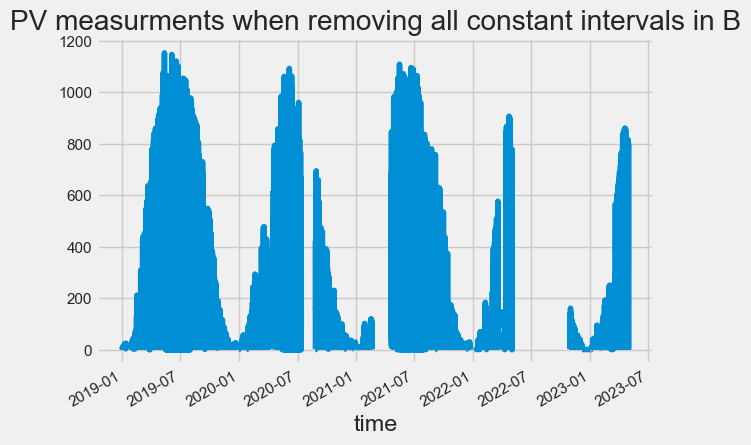

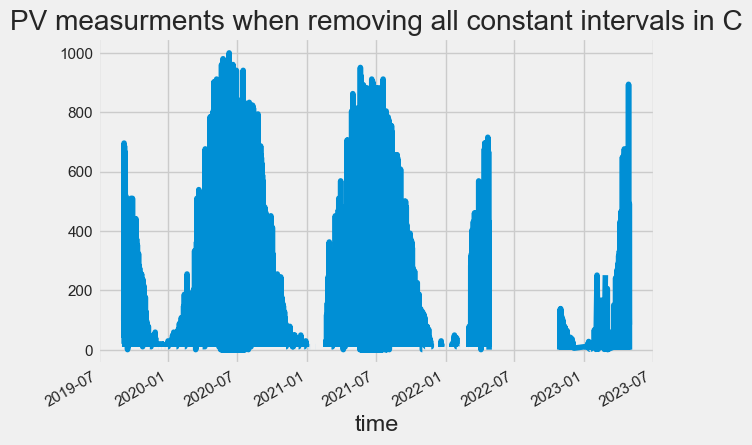

In [69]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [70]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [72]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [73]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [74]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


Setting the index to **date_forecast** and resampling with median.

In [75]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').median()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').median()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').median()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').median()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').median()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').median()


In [76]:
X_train_observed_a.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [77]:
def replace_outliers_with_nan(df, feature):
    '''Replaces thr 0.01 and 0.99'''
    Q1 = df[feature].quantile(0.01)
    Q99 = df[feature].quantile(0.99)

    df[feature] = np.where(
        (df[feature] < Q1) | (df[feature] > Q99),
        np.nan,
        df[feature]
    )

### Removing 'outlier' features as this gave us 0.1 better score on Kaggle

In [78]:
outliers = ['air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa']


for o in outliers:
    replace_outliers_with_nan(X_train_observed_a, o)
    replace_outliers_with_nan(X_train_observed_b, o)
    replace_outliers_with_nan(X_train_observed_c, o)

In [79]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [80]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

In [81]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [82]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,0.0,278.250000,87.500000,16823.399902,2.80,1.20,2.55,-0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,0.0,278.349991,85.350002,16512.299805,2.90,1.10,2.65,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,0.0,278.200012,99.099998,13277.399902,3.65,1.40,3.35,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,0.0,278.100006,99.099998,12777.449707,3.55,1.50,3.20,-0.0,0,NaT
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,0.1,278.050003,97.849998,11142.549805,4.05,2.15,3.45,-0.0,0,NaT


In [83]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10  

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']

    df['ratio_clear_sky_rad_to_cloud_cover'] = df['clear_sky_rad:W'] / (df['effective_cloud_cover:p'] + 1e-8)  # added a small number to avoid division by zero

    df['ratio_direct_to_diffuse_rad'] = df['direct_rad:W'] / (df['diffuse_rad:W'] + 1e-8)

    df['ratio_air_density_to_humidity'] = df['air_density_2m:kgm3'] / (df['absolute_humidity_2m:gm3'] + 1e-8)

    df['ratio_wind_speed_10m_to_1000hPa'] = df['wind_speed_v_10m:ms'] / (df['wind_speed_w_1000hPa:ms'] + 1e-8)

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,ratio_clear_sky_rad_to_cloud_cover,ratio_direct_to_diffuse_rad,ratio_air_density_to_humidity,ratio_wind_speed_10m_to_1000hPa
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,3,0,0.934996,0.354658,-0.0,0.0,0.0,0.0,0.223333,2.550000e+08
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,3,0,0.934934,0.354821,-0.0,0.0,0.0,0.0,0.227706,2.650000e+08
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,3,0,0.761584,0.648067,-0.0,0.0,0.0,0.0,0.231776,3.350000e+08
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,3,0,0.761815,0.647794,-0.0,0.0,0.0,0.0,0.229537,3.200000e+08
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,3,0,0.531894,0.846811,-0.0,0.0,0.0,0.0,0.229352,3.450000e+08


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [84]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 'is_weekend', 'season', 'sun_above_threshold',
    'cos_sun_azimuth', 'sin_sun_azimuth', 'interaction_clear_sky_rad_sun_elevation',
    'interaction_clear_sky_rad_effective_cloud_cover',
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [85]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [86]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3       72
air_density_2m:kgm3          1824
clear_sky_energy_1h:J          72
clear_sky_rad:W                72
dew_or_rime:idx                72
                            ...  
location_A                      0
location_B                      0
location_C                      0
estimated                       0
pv_measurement              40896
Length: 62, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 62, dtype: int64
DROPNA RESULTED IN 42788 ROWS BEING DROPPED. THE DATASET HAS 56298 ROWS IN TOTAL.


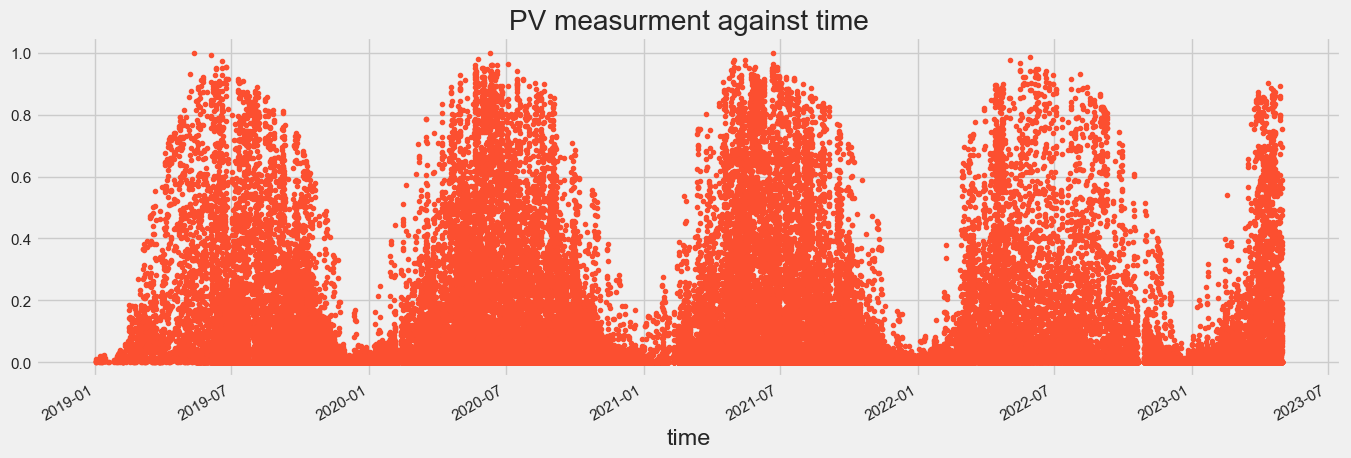

In [87]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [88]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    x_test = x_test.resample('60min').median()

    x_test = create_features(x_test)

    if location == 'A':
        x_test['location_A'] =  1
        x_test['location_B'] = 0
        x_test['location_C'] = 0
    elif location == 'B':
        x_test['location_A'] =  0
        x_test['location_B'] = 1
        x_test['location_C'] = 0
    elif location == 'C':
        x_test['location_A'] =  0
        x_test['location_B'] = 0
        x_test['location_C'] = 1

    return x_test

In [89]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [90]:
test_sub = pd.read_csv('../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [91]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_b.loc[valid_dates]
x_test_c = x_test_c.loc[valid_dates]

In [92]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

### Disability Check

Check if the training data and the test data contains the same columns.

In [93]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [94]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [95]:
X_train = df[FEATURES]
y_train = df[TARGET]

In [96]:
X_train.shape, y_train.shape, X_test.shape  

((56298, 61), (56298,), (2160, 61))

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
# import dask.dataframe as dd  # Commented as dask is not in your installed list

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Activation, Dropout, Flatten,
    LSTM, Conv1D, MaxPool2D, Conv2D, MaxPooling2D, TimeDistributed,
    LeakyReLU, PReLU  # These activations are now part of tf.keras.layers
)

from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

#from keijzer import setup_multi_gpus, create_corr_matrix, reduce_memory, resample_df, df_to_lstm_format

mpl.style.use('default')
# %matplotlib notebook
%matplotlib inline
sns.set()


## Preprocessing, data to lstm format

In [107]:
def df_to_cnn_rnn_format(df, train_size=0.5, look_back=5, target_column='target', scale_X=True):
    """
    TODO: output train and test datetime
    Input is a Pandas DataFrame. 
    Output is a np array in the format of (samples, timesteps, features).
    Currently this function only accepts one target variable.

    Usage example:

    # variables
    df = data # should be a pandas dataframe
    test_size = 0.5 # percentage to use for training
    target_column = 'c' # target column name, all other columns are taken as features
    scale_X = False
    look_back = 5 # Amount of previous X values to look at when predicting the current y value
    """
    df = df.copy()

    # Make sure the target column is the last column in the dataframe
    df['target'] = df[target_column] # Make a copy of the target column
    df = df.drop(columns=[target_column]) # Drop the original target column
    
    target_location = df.shape[1] - 1 # column index number of target
    split_index = int(df.shape[0]*train_size) # the index at which to split df into train and test
    
    # ...train
    X_train = df.values[:split_index, :target_location]
    y_train = df.values[:split_index, target_location]

    # ...test
    X_test = df.values[split_index:, :target_location] # original is split_index:-1
    #y_test = df.values[split_index:, target_location] # original is split_index:-1

    # Scale the features
    if scale_X:
        scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
        X_train = scalerX.transform(X_train)
        #X_test = scalerX.transform(X_test)
        
    # Reshape the arrays
    samples = len(X_train) # in this case 217 samples in the training set
    num_features = target_location # All columns before the target column are features

    samples_train = X_train.shape[0] - look_back
    X_train_reshaped = np.zeros((samples_train, look_back, num_features))
    y_train_reshaped = np.zeros((samples_train))

    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]

    
    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    #y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        #y_test_reshaped[i] = y_test[y_position]
    
    
    return X_train_reshaped, y_train_reshaped, X_test_reshaped
    # return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped



In [99]:
def setup_multi_gpus():
    """
    Setup multi GPU usage

    Example usage:
    model = Sequential()
    ...
    multi_model = multi_gpu_model(model, gpus=num_gpu)
    multi_model.fit()
    """
    import tensorflow as tf
    from keras.utils.training_utils import multi_gpu_model
    from tensorflow.python.client import device_lib

    # IMPORTANT: Tells tf to not occupy a specific amount of memory
    from keras.backend.tensorflow_backend import set_session  
    config = tf.ConfigProto()  
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
    sess = tf.Session(config=config)  
    set_session(sess)  # set this TensorFlow session as the default session for Keras.

    
    # getting the number of GPUs 
    def get_available_gpus():
       local_device_protos = device_lib.list_local_devices()
       return [x.name for x in local_device_protos if x.device_type    == 'GPU']
    
    num_gpu = len(get_available_gpus())
    print('Amount of GPUs available: %s' % num_gpu)
    
    return num_gpu



In [100]:
def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df



In [101]:
def resample_df(df, sample_rate, combine_all_dwellings=False):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df.
    Input df may also be multiple dwelling dfs combined.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    
    Combine all dwellings: resamples the df and ignores the fact that there are unique dwellings.
    
    TODO: add std to ePower, gasPower when combine_all_dwellings=False
    """
    df = df.copy()
    
    def resample_dwelling(df, sample_rate, dwelling_id):
        new_df = df.resample(sample_rate).mean() # resample to rest by mean
        new_df['dwelling'] = dwelling_id
        if combine_all_dwellings:
            new_df['gasPower_std'] = df['gasPower'].resample(sample_rate).std() # gives the std (for example that day)
        return new_df
        
                      
    resampled_dwellings = []
    
    if combine_all_dwellings: # Ignore dwelling_ids
        df = df.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Drop columns because they are meaningless when ignoring dwelling ids
        resampled_df = resample_dwelling(df, sample_rate, 'All dwellings')
        resampled_dwellings.append(resampled_df)
    else:
        dwellings = df['dwelling'].unique() # Get dwelling ids
        for dwelling_id in tqdm(dwellings):
            dwelling_df = df[df['dwelling'] == dwelling_id] # Get the data from only that dwelling_id
            resampled_dwelling = resample_dwelling(dwelling_df, sample_rate, dwelling_id)
            resampled_dwellings.append(resampled_dwelling)
    
    resampled_df = pd.concat(resampled_dwellings)
    
    return resampled_df



In [102]:
def abs_percentage_error(y_true, y_pred):
    import keras.backend as K
    """
    Returns the absolute value of the difference between y_true and y_pred (in percentage).
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100



In [103]:
df.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'hour', 'dayofweek', 'quarter',

In [108]:
look_back = 5*24 # D -> 5, H -> 5*24
num_features = X_train.shape[1] - 1
output_dim = 1
test_size = 0.7
X_train, y_train, X_test = df_to_cnn_rnn_format(df=df, train_size=test_size, look_back=look_back, target_column='pv_measurement', scale_X=True)
X_train.shape

(39288, 120, 61)

## Letsgo imports

In [45]:
num_gpu = setup_multi_gpus()

NameError: name 'setup_multi_gpus' is not defined

In [37]:
import optuna
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 100.0),
        'loss_function':'MAE'
    }

    cv_dataset = Pool(data=X_train, label=y_train)


    scores = cv(cv_dataset,
                    params=param,
                    fold_count=5,
                    plot=True,
                    type="TimeSeries",
                    verbose=False)
    

    # Extract the best score
    best_score = np.min(scores['test-MAE-mean'])
    
    return best_score

In [38]:
trials = 2

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=trials, n_jobs=-1, show_progress_bar=True)  

[I 2023-10-25 14:33:48,784] A new study created in memory with name: no-name-1495ed34-53c6-4627-8149-e201fde2d66d


  0%|          | 0/2 [00:00<?, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
Training on fold [0/5]

bestTest = 0.1027447322
bestIteration = 1047

Training on fold [1/5]

bestTest = 0.07889168434
bestIteration = 1438

Training on fold [1/5]

bestTest = 0.06333791762
bestIteration = 1047

Training on fold [2/5]

bestTest = 0.04504201445
bestIteration = 1438

Training on fold [2/5]

bestTest = 0.1456597064
bestIteration = 1047

Training on fold [3/5]

bestTest = 0.1023557239
bestIteration = 1438

Training on fold [3/5]

bestTest = 0.06577083374
bestIteration = 1047

Training on fold [4/5]

bestTest = 0.04731896261
bestIteration = 1438

Training on fold [4/5]

bestTest = 0.06183073409
bestIteration = 1047

[I 2023-10-25 14:37:14,501] Trial 0 finished with value: 0.08786878479897291 and parameters: {'iterations': 1048, 'learning_rate': 0.0005546965997901217, 'depth': 12, 'colsample_bylevel': 0.6335719521490355, 'min_data_in_leaf': 140, 'l2_leaf_reg': 1.4699051229072484e-06, 'border_count': 121, 'bagging_temperature': 17.754935938395498}. Best

In [36]:
best_params = study.best_params
print('Best parameters:', best_params)

#Best parameters: {'iterations': 854, 'learning_rate': 0.017432099489773544, 'depth': 14, 'colsample_bylevel': 0.43559465187532453, 'min_data_in_leaf': 257, 'l2_leaf_reg': 9.179321889625692, 'border_count': 129, 'random_strength': 0.8781261706316226, 'bagging_temperature': 11.599929150721326, 'grow_policy': 'Lossguide', 'max_leaves': 192}

ValueError: No trials are completed yet.

In [ ]:
model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train)


0:	learn: 0.2079457	total: 73.1ms	remaining: 1m 20s
1:	learn: 0.2058035	total: 132ms	remaining: 1m 12s
2:	learn: 0.2037307	total: 222ms	remaining: 1m 21s
3:	learn: 0.2016787	total: 280ms	remaining: 1m 16s
4:	learn: 0.1996572	total: 351ms	remaining: 1m 16s
5:	learn: 0.1976167	total: 411ms	remaining: 1m 15s
6:	learn: 0.1956068	total: 466ms	remaining: 1m 12s
7:	learn: 0.1936837	total: 521ms	remaining: 1m 11s
8:	learn: 0.1917575	total: 572ms	remaining: 1m 9s
9:	learn: 0.1899462	total: 621ms	remaining: 1m 7s
10:	learn: 0.1880487	total: 672ms	remaining: 1m 6s
11:	learn: 0.1861768	total: 725ms	remaining: 1m 5s
12:	learn: 0.1843446	total: 778ms	remaining: 1m 5s
13:	learn: 0.1825366	total: 830ms	remaining: 1m 4s
14:	learn: 0.1807667	total: 882ms	remaining: 1m 3s
15:	learn: 0.1790382	total: 933ms	remaining: 1m 3s
16:	learn: 0.1773367	total: 981ms	remaining: 1m 2s
17:	learn: 0.1756428	total: 1.03s	remaining: 1m 2s
18:	learn: 0.1739654	total: 1.09s	remaining: 1m 2s
19:	learn: 0.1723738	total: 1.15

### Feature importance

In [ ]:
feature_importances = model.get_feature_importance()
print("\nFeature Importances:\n")
for score, name in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f'{name}: {score:.2f}')


Feature Importances:

direct_rad:W: 27.40
sun_elevation:d: 17.85
direct_rad_1h:J: 11.87
clear_sky_rad:W: 10.60
interaction_clear_sky_rad_sun_elevation: 6.68
clear_sky_energy_1h:J: 4.21
diffuse_rad:W: 2.14
diffuse_rad_1h:J: 1.70
effective_cloud_cover:p: 1.55
sun_above_threshold: 1.28
visibility:m: 0.92
total_cloud_cover:p: 0.83
relative_humidity_1000hPa:p: 0.76
wind_speed_u_10m:ms: 0.73
interaction_clear_sky_rad_effective_cloud_cover: 0.67
elevation:m: 0.65
location_A: 0.64
t_1000hPa:K: 0.53
cos_sun_azimuth: 0.52
dayofmonth: 0.49
sin_sun_azimuth: 0.44
wind_speed_10m:ms: 0.42
absolute_humidity_2m:gm3: 0.42
msl_pressure:hPa: 0.40
year: 0.40
dew_point_2m:K: 0.40
sun_azimuth:d: 0.38
wind_speed_v_10m:ms: 0.38
pressure_100m:hPa: 0.35
hour: 0.34
dayofyear: 0.33
pressure_50m:hPa: 0.32
sfc_pressure:hPa: 0.31
air_density_2m:kgm3: 0.30
weekofyear: 0.28
precip_type_5min:idx: 0.23
dayofweek: 0.22
snow_water:kgm2: 0.21
super_cooled_liquid_water:kgm2: 0.19
month: 0.18
quarter: 0.17
precip_5min:mm: 0.

### Predict and make csv

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

predictions.head()

,prediction
0,-0.000486
1,-0.000246
2,-0.000120
3,0.010406
4,0.068582


In [ ]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [ ]:

n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))


In [ ]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [ ]:
predictions.head(10)

,prediction
0,-2.788860
1,-1.411204
2,-0.689793
3,59.660320
4,393.209798
5,972.074656
6,1856.884106
7,2831.886790
8,3040.260545
9,3191.299135


In [ ]:
predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [ ]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

Redifing the training sets

In [ ]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

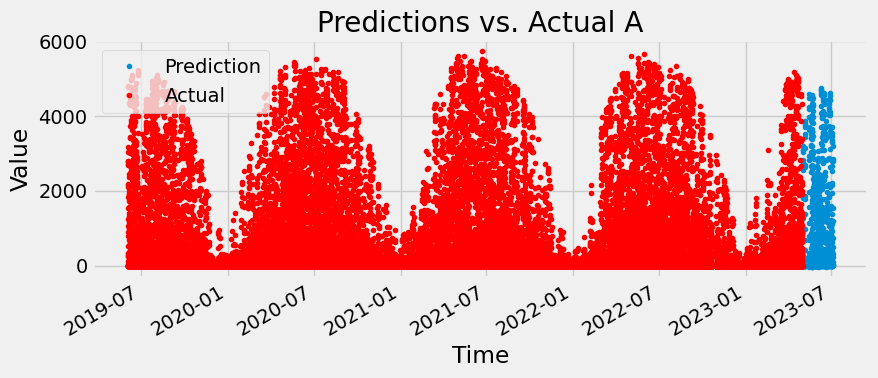

In [ ]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting B

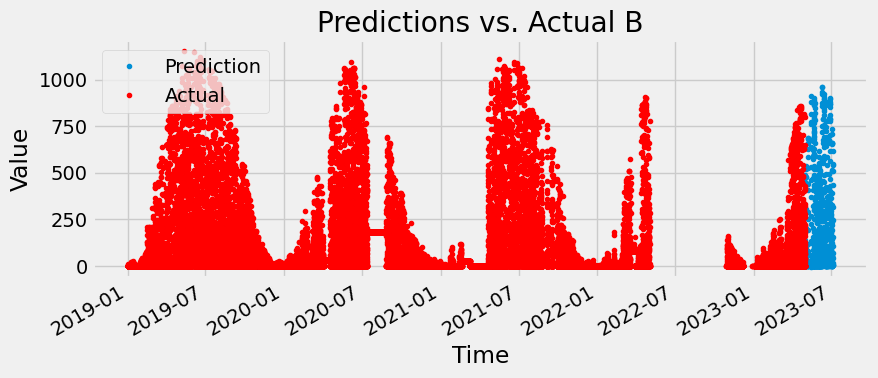

In [ ]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


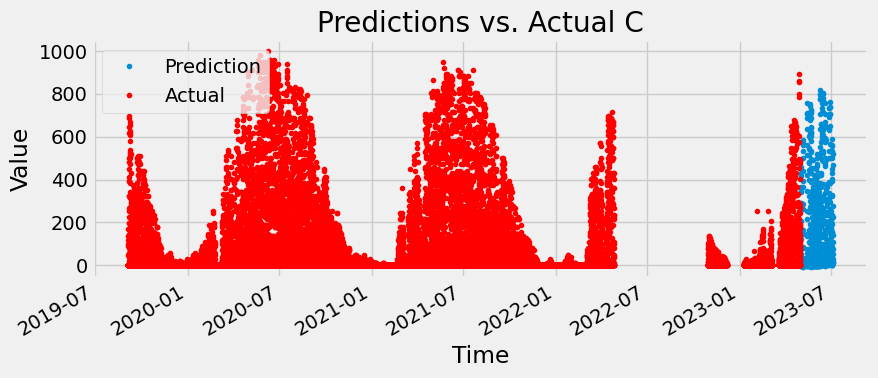

In [ ]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

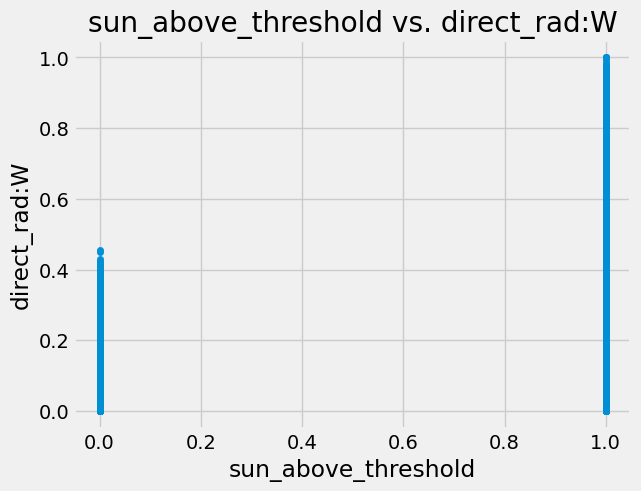

In [ ]:
df.plot(x='sun_above_threshold', y='pv_measurement', kind='scatter')
plt.xlabel('sun_above_threshold')
plt.ylabel('direct_rad:W')
plt.title('sun_above_threshold vs. direct_rad:W')
plt.show()